In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForImageClassification, AutoImageProcessor
from datasets import load_dataset
from src.gradient_rollout import AttentionGradRollout
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm
from PIL import Image

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.image_utils import show_mask_on_image
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])

import cv2

In [18]:
device = 'cuda'

In [72]:
image_processor = AutoImageProcessor.from_pretrained(
    "google/vit-base-patch16-224",
    cache_dir = '/Data'
)
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    attn_implementation = 'eager',
    cache_dir = '/Data'
)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [73]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [74]:
dataset = load_dataset(
    "microsoft/cats_vs_dogs",
    cache_dir='/Data',
    split = 'train'
)

In [75]:
for name, _ in model.named_modules():
    print(name)


vit
vit.embeddings
vit.embeddings.patch_embeddings
vit.embeddings.patch_embeddings.projection
vit.embeddings.dropout
vit.encoder
vit.encoder.layer
vit.encoder.layer.0
vit.encoder.layer.0.attention
vit.encoder.layer.0.attention.attention
vit.encoder.layer.0.attention.attention.query
vit.encoder.layer.0.attention.attention.key
vit.encoder.layer.0.attention.attention.value
vit.encoder.layer.0.attention.attention.dropout
vit.encoder.layer.0.attention.output
vit.encoder.layer.0.attention.output.dense
vit.encoder.layer.0.attention.output.dropout
vit.encoder.layer.0.intermediate
vit.encoder.layer.0.intermediate.dense
vit.encoder.layer.0.intermediate.intermediate_act_fn
vit.encoder.layer.0.output
vit.encoder.layer.0.output.dense
vit.encoder.layer.0.output.dropout
vit.encoder.layer.0.layernorm_before
vit.encoder.layer.0.layernorm_after
vit.encoder.layer.1
vit.encoder.layer.1.attention
vit.encoder.layer.1.attention.attention
vit.encoder.layer.1.attention.attention.query
vit.encoder.layer.1.atte

In [124]:
metric = AttentionGradRollout(model, attention_layer_name='attention.dropout', is_vit=True, discard_ratio=0.8)

In [125]:
cat_dog_img = Image.open("data/dog_cat.png")

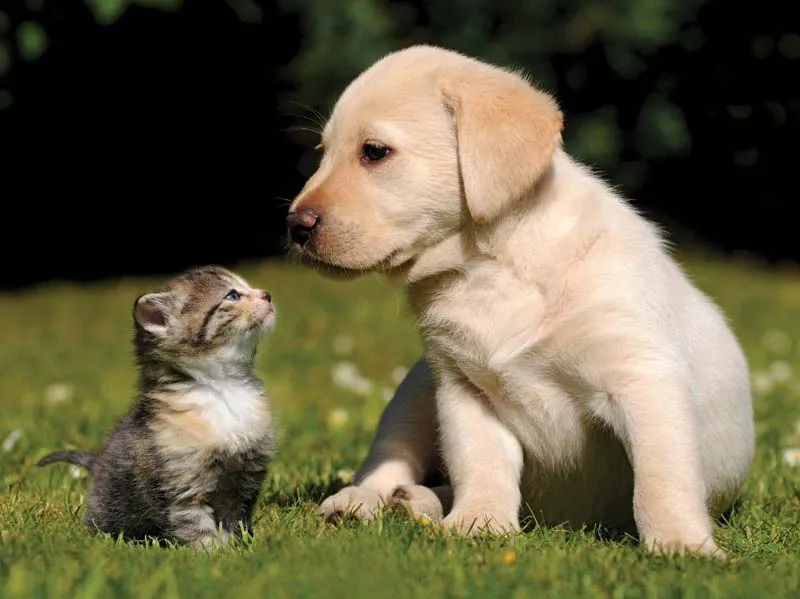

In [126]:
cat_dog_img

In [127]:
golden_retriever_idx = 207
cat_idx = 282

In [128]:
def get_grad_rollout_scores(img : Image, target_class : int):
    tokens = image_processor(images=img, return_tensors='pt')

    print(target_class)
    tokens['labels'] = torch.tensor(target_class, device = device)

    # Perform inference and attention rollout
    outputs = metric(**tokens, output_attentions=True)

    attention = outputs[1]

    # Convert image to NumPy format for visualization
    np_img = np.array(img)[:, :, ::-1]
    mask = cv2.resize(attention, (np_img.shape[1], np_img.shape[0]))
    img_focus = show_mask_on_image(np_img, mask)

    return img_focus

207
282


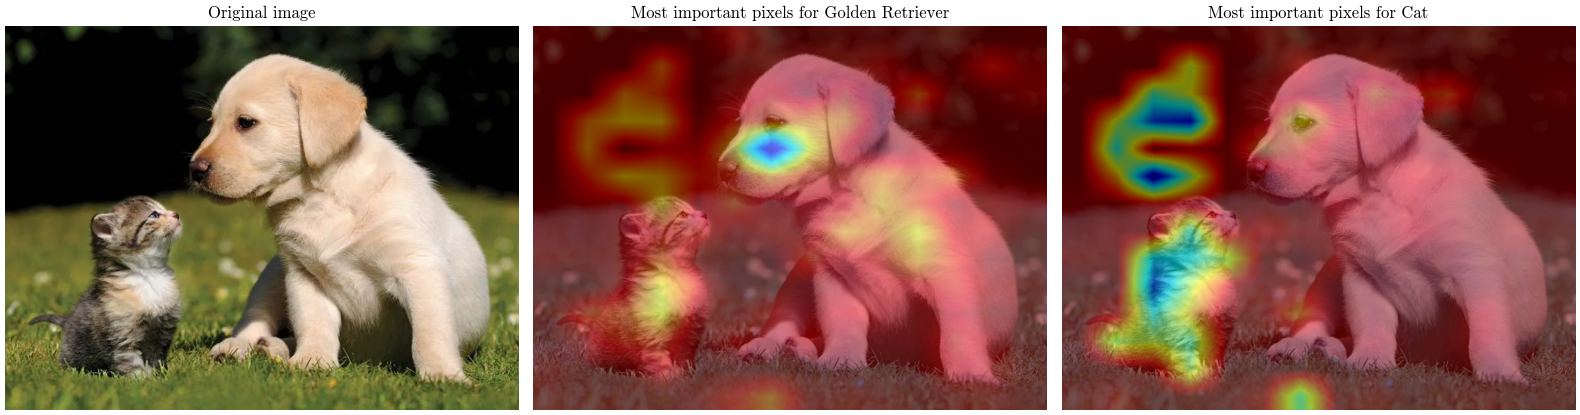

In [129]:
num_images = 1
fig, axes = plt.subplots(num_images, 3, figsize=(16, 5 * num_images))


# Process image tokens

img_focus_golden = get_grad_rollout_scores(cat_dog_img, golden_retriever_idx)
img_focus_cat = get_grad_rollout_scores(cat_dog_img, cat_idx)

# Display original image
axes[0].imshow(cat_dog_img)
axes[0].axis("off")
axes[0].set_title("Original image")


# Display attention map
axes[1].imshow(img_focus_golden)
axes[1].axis("off")
axes[1].set_title("Most important pixels for Golden Retriever")

axes[2].imshow(img_focus_cat)
axes[2].axis("off")
axes[2].set_title("Most important pixels for Cat")

# Adjust layout
plt.tight_layout()
plt.show()

In [135]:
car_bike_img = Image.open("data/car_bike.jpeg")

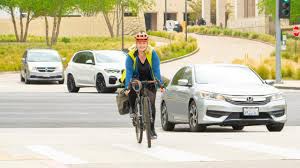

In [136]:
car_bike_img

In [143]:
car_idx = 479
bike_idx = 444

479
444


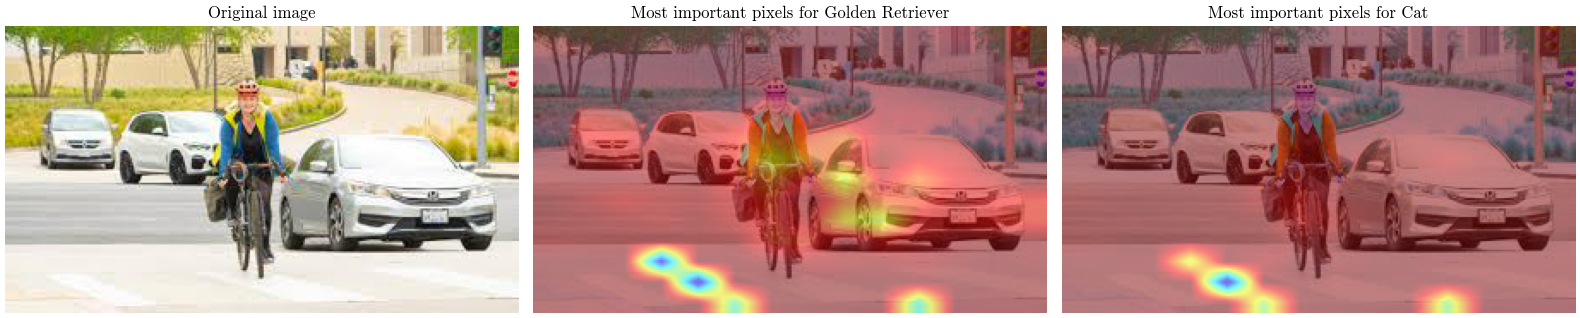

In [145]:
num_images = 1
fig, axes = plt.subplots(num_images, 3, figsize=(16, 5 * num_images))


# Process image tokens

img_focus_car = get_grad_rollout_scores(car_bike_img, car_idx)
img_focus_bike = get_grad_rollout_scores(car_bike_img, bike_idx)

# Display original image
axes[0].imshow(car_bike_img)
axes[0].axis("off")
axes[0].set_title("Original image")


# Display attention map
axes[1].imshow(img_focus_car)
axes[1].axis("off")
axes[1].set_title("Most important pixels for Car Wheel")

axes[2].imshow(img_focus_bike)
axes[2].axis("off")
axes[2].set_title("Most important pixels for Bicycle")

# Adjust layout
plt.tight_layout()
plt.show()